In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, TimeDistributed, Conv1D, LSTM, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
# from tensorflow_addons.optimizers import CyclicalLearningRate
import glob
import os
import csv


In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [19]:
def merge_csi_label(csifile, labelfile, win_len=300, thrshd=0.6, step=50):
    activity = []
    with open(labelfile, 'r') as labelf:
        reader = csv.reader(labelf)
        for line in reader:
            label  = line[0]
            if label == 'NoActivity':
                activity.append(0)
            else:
                activity.append(1)
    activity = np.array(activity)
    csi = []
    with open(csifile, 'r') as csif:
        reader = csv.reader(csif)
        for line in reader:
            line_array = np.array([float(v) for v in line])
            # extract the amplitude only
            line_array = line_array[0:52]
            csi.append(line_array[np.newaxis,...])
    csi = np.concatenate(csi, axis=0)
    assert(csi.shape[0] == activity.shape[0])
    # screen the data with a window
    index = 0
    feature = []
    while index + win_len <= csi.shape[0]:
        cur_activity = activity[index:index+win_len]
        if np.sum(cur_activity)  <  thrshd * win_len:
            index += step
            continue
        cur_feature = np.zeros((1, win_len, 52))
        cur_feature[0] = csi[index:index+win_len, :]
        feature.append(cur_feature)
        index += step
    return np.concatenate(feature, axis=0)

In [20]:
def extract_csi_by_label(raw_folder, label, labels, save=False, win_len=300, thrshd=0.6, step=50):
    print('Starting Extract CSI for Label {}'.format(label))
    label = label.lower()
    if not label in labels:
        raise ValueError("The label {} should be among 'lie down','fall','bend','run','sitdown','standup','walk'".format(labels))
    data_path_pattern = os.path.join(raw_folder,label, 'user_*' + label + '*.csv')
    input_csv_files = sorted(glob.glob(data_path_pattern))
    # annot_csv_files = [os.path.basename(fname).replace('user_', 'annotation_user') for fname in input_csv_files]
    # annot_csv_files = [os.path.join(raw_folder, label, fname) for fname in annot_csv_files]
    annot_csv_files = os.path.join(raw_folder,label, 'Annotation_user_*' + label + '*.csv')
    annot_csv_files = sorted(glob.glob(annot_csv_files))
    feature = []
    index = 0
    for csi_file, label_file in zip(input_csv_files, annot_csv_files):
        index += 1
        if not os.path.exists(label_file):
            print('Warning! Label File {} doesn\'t exist.'.format(label_file))
            continue
        feature.append(merge_csi_label(csi_file, label_file, win_len=win_len, thrshd=thrshd, step=step))
        print('Finished {:.2f}% for Label {}'.format(index / len(input_csv_files) * 100,label))
    
    feat_arr = np.concatenate(feature, axis=0)
    if save:
        np.savez_compressed("X_{}.npz".format(label), feat_arr)
    # one hot
    feat_label = np.zeros((feat_arr.shape[0], len(labels)))
    feat_label[:, labels.index(label)] = 1
    return feat_arr, feat_label

In [21]:
def extract_csi(raw_folder, labels, save=False, win_len=300, thrshd=0.6, step=50):
    ans = []
    for label in labels:
        feature_arr, label_arr = extract_csi_by_label(raw_folder, label, labels, save, win_len, thrshd, step)
        ans.append(feature_arr)
        ans.append(label_arr)
    return tuple(ans)


In [22]:
class CSIModelConfig:
    def __init__(self, win_len=300, step=50, thrshd=0.6):
        self._win_len = win_len
        self._step = step
        self._thrshd = thrshd
        self._labels = ("lie down", "fall", "bend", "run", "sitdown", "standup", "walk")
        # self._downsample = downsample

    def preprocessing(self, raw_folder, save=False):
        numpy_tuple = extract_csi(raw_folder, self._labels, save, self._win_len, self._thrshd, self._step)
        # if self._downsample > 1:
        #     return tuple([v[:, ::self._downsample,...] if i%2 ==0 else v for i, v in enumerate(numpy_tuple)])
        return numpy_tuple
    
    def load_csi_data_from_files(self, np_files):
        if len(np_files) != 7:
            raise ValueError('There should be 7 numpy files for lie down, fall, bend, run, sitdown, standup, walk.')
        x = [np.load(f)['arr_0'] for f in np_files]
        # if self._downsample > 1:
        #     x = [arr[:,::self._downsample, :] for arr in x]
        y = [np.zeros((arr.shape[0], len(self._labels))) for arr in x]
        numpy_list = []
        for i in range(len(self._labels)):
            y[i][:,i] = 1
            numpy_list.append(x[i])
            numpy_list.append(y[i])
        return tuple(numpy_list)

In [23]:
def train_valid_split(numpy_tuple, train_portion=0.8, seed=200):
    np.random.seed(seed=seed)
    x_train = []
    x_valid = []
    y_valid = []
    y_train = []

    for i, x_arr in enumerate(numpy_tuple):
        index = np.random.permutation([i for i in range(x_arr.shape[0])])
        split_len = int(train_portion * x_arr.shape[0])
        x_train.append(x_arr[index[:split_len], ...])
        tmpy = np.zeros((split_len,7))
        tmpy[:, i] = 1
        y_train.append(tmpy)
        x_valid.append(x_arr[index[split_len:],...])
        tmpy = np.zeros((x_arr.shape[0]-split_len,7))
        tmpy[:, i] = 1
        y_valid.append(tmpy)
    
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    x_valid = np.concatenate(x_valid, axis=0)
    y_valid = np.concatenate(y_valid, axis=0)

    index = np.random.permutation([i for i in range(x_train.shape[0])])
    x_train = x_train[index, ...]
    y_train = y_train[index, ...]
    return x_train, y_train, x_valid, y_valid

In [24]:
cfg = CSIModelConfig(win_len=300, step=50, thrshd=0.6)
numpy_tuple = cfg.preprocessing('/Users/sayakghorai/Desktop/Sem_Vi/ML/Lab1/CSI-HAR-Dataset/CSI-HAR-Dataset', save=True)

x_lie_down, y_lie_down, x_fall, y_fall, x_bend, y_bend, x_run, y_run, x_sitdown, y_sitdown, x_standup, y_standup, x_walk, y_walk = numpy_tuple
x_train, y_train, x_valid, y_valid = train_valid_split((x_lie_down, x_fall, x_bend, x_run, x_sitdown, x_standup, x_walk),train_portion=0.8, seed=200)
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

Starting Extract CSI for Label lie down
Finished 1.67% for Label lie down
Finished 3.33% for Label lie down
Finished 5.00% for Label lie down
Finished 6.67% for Label lie down
Finished 8.33% for Label lie down
Finished 10.00% for Label lie down
Finished 11.67% for Label lie down
Finished 13.33% for Label lie down
Finished 15.00% for Label lie down
Finished 16.67% for Label lie down
Finished 18.33% for Label lie down
Finished 20.00% for Label lie down
Finished 21.67% for Label lie down
Finished 23.33% for Label lie down
Finished 25.00% for Label lie down
Finished 26.67% for Label lie down
Finished 28.33% for Label lie down
Finished 30.00% for Label lie down
Finished 31.67% for Label lie down
Finished 33.33% for Label lie down
Finished 35.00% for Label lie down
Finished 36.67% for Label lie down
Finished 38.33% for Label lie down
Finished 40.00% for Label lie down
Finished 41.67% for Label lie down
Finished 43.33% for Label lie down
Finished 45.00% for Label lie down
Finished 46.67% for 

In [29]:
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(96, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.0001)))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.0001)))
model.add(Dropout(0.15))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 300, 128)       │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 300, 96)        │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 300, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48)             │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,463 (951.03 KB)

 Trainable params: 243,463 (951.03 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

checkpoint = ModelCheckpoint("lstm_11.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.0001, verbose=1)

# reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=6,
#                               verbose=1,
#                               min_delta=0.0001)

callbacks_list = [checkpoint, early_stopping]

In [31]:
verbose, epochs, batch_size = 1, 300, 48
opt= Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history=model.fit(
        x_train,
        y_train,verbose=verbose,
        batch_size=batch_size, epochs=epochs,
        validation_split=0.2,
        callbacks=callbacks_list)


Epoch 1/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1944 - loss: 2.8735
Epoch 1: val_accuracy improved from -inf to 0.45254, saving model to lstm_11.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.1955 - loss: 2.8727 - val_accuracy: 0.4525 - val_loss: 2.6772
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3758 - loss: 2.6498
Epoch 2: val_accuracy improved from 0.45254 to 0.57772, saving model to lstm_11.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.3762 - loss: 2.6486 - val_accuracy: 0.5777 - val_loss: 2.3587
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4546 - loss: 2.3568
Epoch 3: val_accuracy improved from 0.57772 to 0.58872, saving model to lstm_11.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.4549 - loss: 2.3560 - val_accuracy: 0.5887 - val_loss: 2.1137
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5443 - loss: 2.1527
Epoch 4: val_accuracy did not improve from 0.

: 

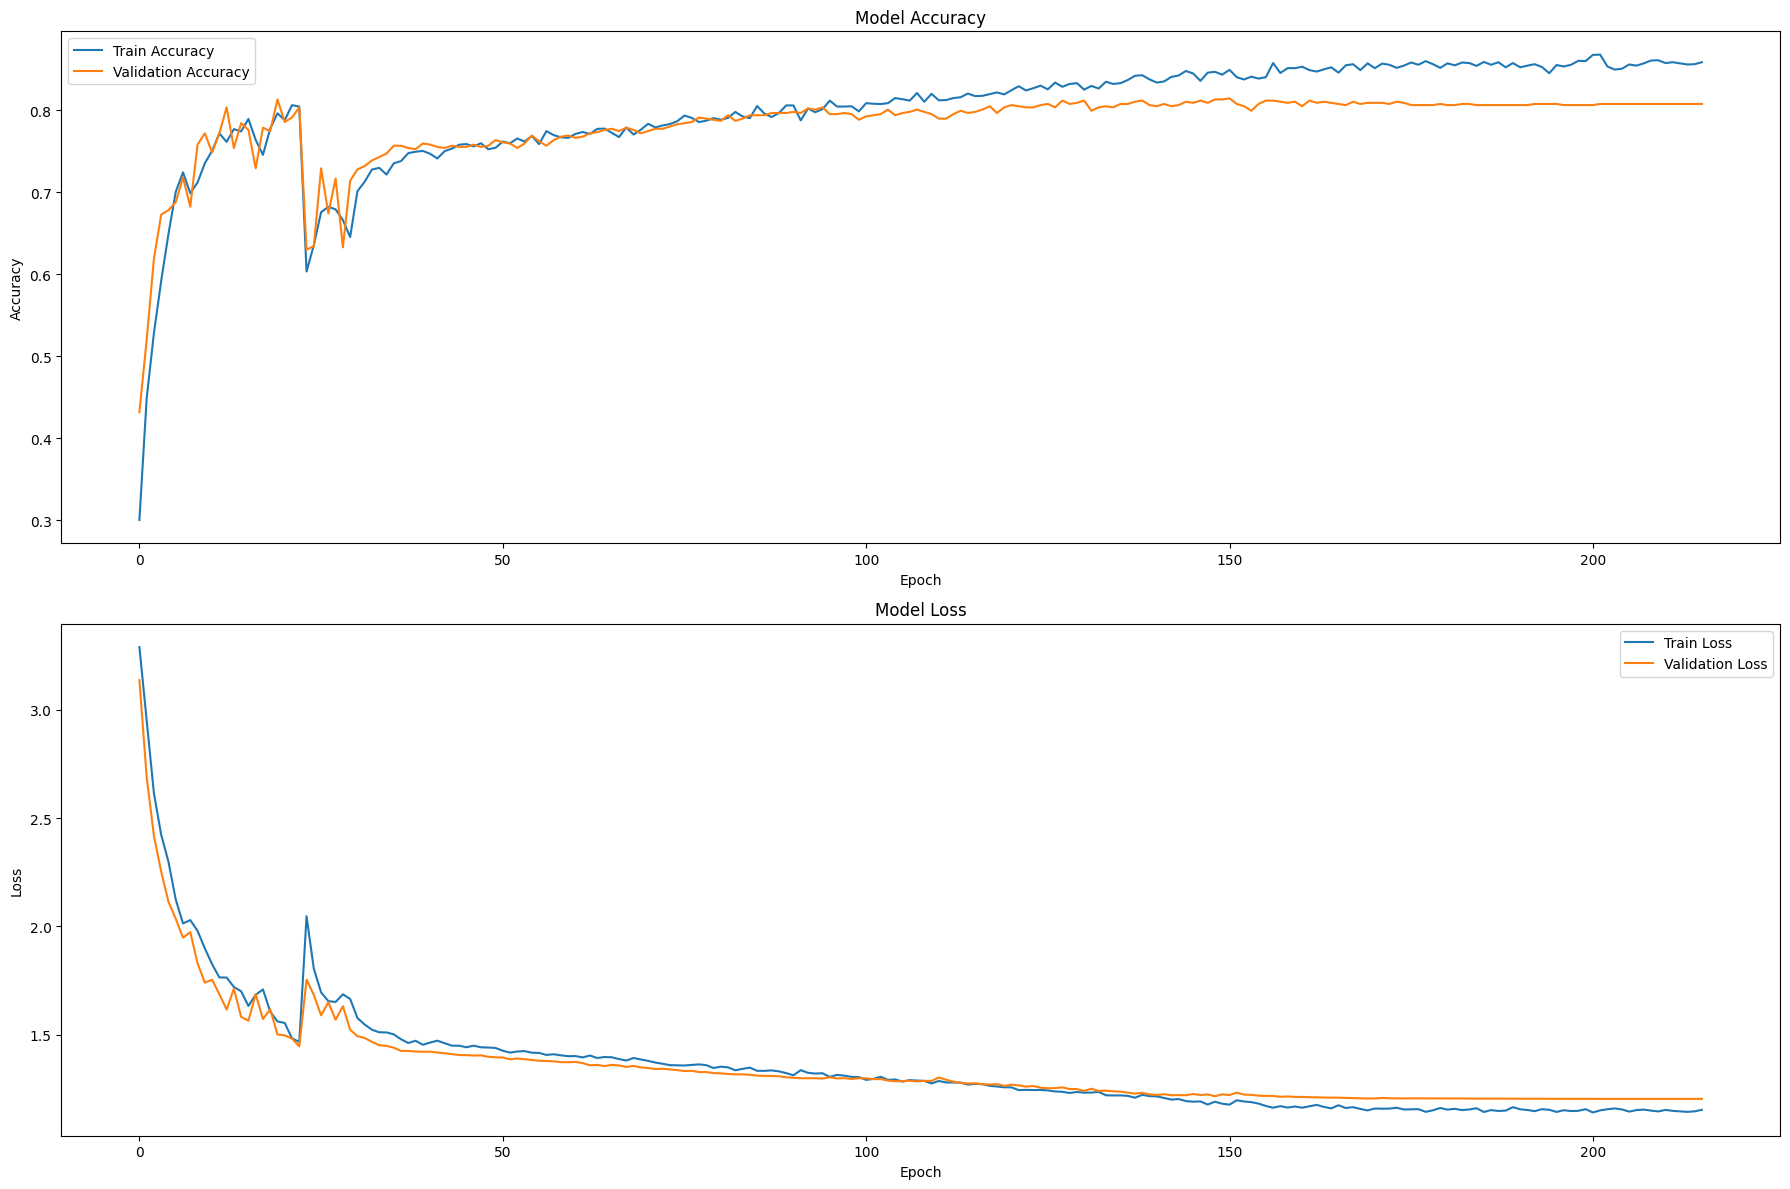

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation metrics
plt.figure(figsize=(18, 12))

# Plot training & validation accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate model
model = tf.keras.models.load_model("model2/lstm_8.keras")
loss , accuracy = model.evaluate(x_valid, y_valid, batch_size=batch_size, verbose=1)
print("Loss: ",loss, "Accuracy: ",accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8871 - loss: 0.6422
Loss:  0.6207295060157776 Accuracy:  0.8946213126182556


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


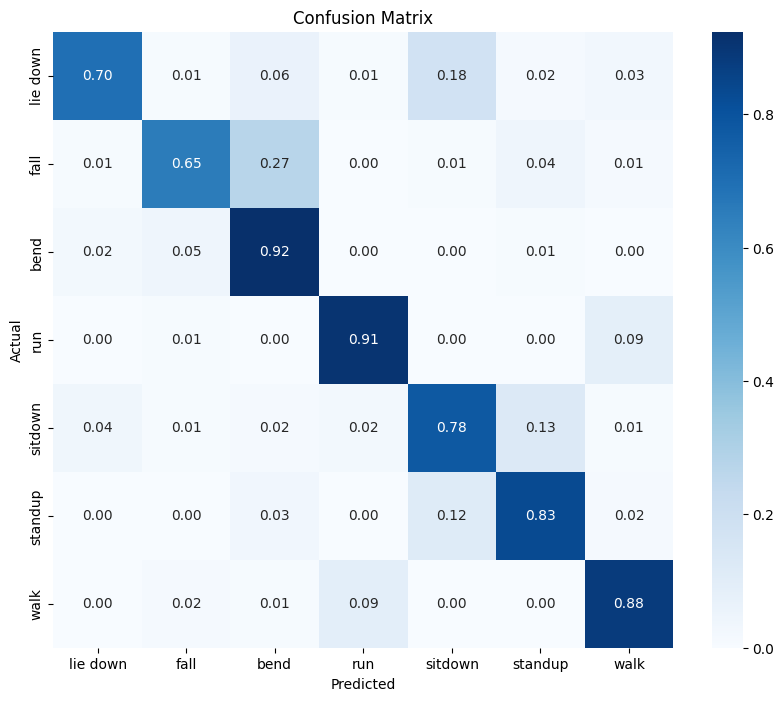

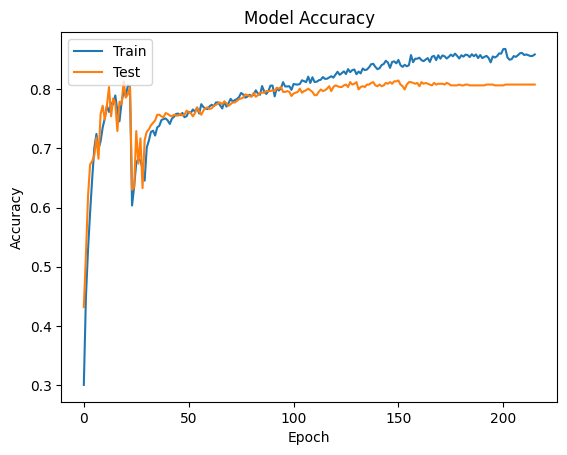

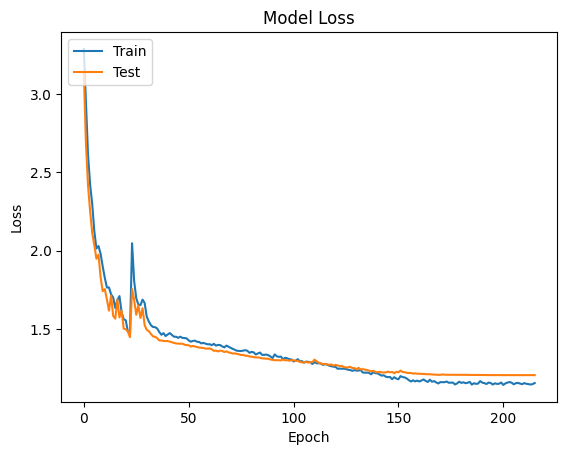

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
y_pred = model.predict(x_valid)
cm = confusion_matrix(np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1), normalize='true')

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=["lie down", "fall", "bend", "run", "sitdown", "standup", "walk"], 
            yticklabels=["lie down", "fall", "bend", "run", "sitdown", "standup", "walk"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
